In [1]:
# Experimental classifier that uses a CNN architecture and softmax activation in the last layer

import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
from sklearn.model_selection import train_test_split

In [2]:
# Load the datasets

data_path = '/Users/ec270266/Documents/Phd/Euclid/dev/output/psf_dataset/'
test_dataset = np.load(data_path + 'test_Euclid_res_20000_TestStars_id_002GT_100_bins.npy', allow_pickle=True)[()]
train_dataset = np.load(data_path + 'train_Euclid_res_52000_TrainStars_id_002GT_100_bins.npy', allow_pickle=True)[()]

In [3]:
test_size=len(test_dataset['stars'])
train_size=len(train_dataset['stars'])

In [4]:
def calculate_success_rate(confusion_matrix):
    """ Metric that contemplates success as the true spectral class with a tolerance of one adjacent class
    """
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    """ Callback to display training information only at the end of the training of one network
    """
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]
        final_acc = self.model.history.history['categorical_accuracy'][-1]
        final_val_acc = self.model.history.history['val_categorical_accuracy'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)
        print("Final accuracy:", final_acc, "Final validation accuracy:", final_val_acc)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

class CNN_model:
    """Wrapper class to train the network with a PCA dataset and a given architecture."""
    def __init__(self, train_dataset, test_dataset, architecture):
        """Receives the name of the dataset and the already created network and loads the needed variables."""
        
        only_train_stars = False
        if only_train_stars:
            train_stars = np.expand_dims(train_dataset['noisy_stars'], axis = 3)
            x_train, self.x_test, y_train, self.y_test = train_test_split(
                train_stars, train_dataset['SED_ids'], test_size = int(train_size/2.6), shuffle = False
            )
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                x_train, y_train, test_size = int(train_size/2.6/2.6), shuffle = False
            )
        else:
            train_stars = np.expand_dims(train_dataset['noisy_stars'], axis = 3)
            self.x_test = np.expand_dims(test_dataset['noisy_stars'], axis = 3)
            self.y_test = test_dataset['SED_ids']
        
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                train_stars, train_dataset['SED_ids'],test_size = test_size, shuffle = False
            )

        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train,num_classes = 13)
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val,num_classes = 13)
        self.y_test_cat = tf.keras.utils.to_categorical(self.y_test,num_classes = 13)
        
        self.learning = []
        self.model = architecture
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs):

        self.model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate),
            metrics = 'categorical_accuracy'
        )
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)

        learn = self.model.fit(self.x_train, self.y_train_cat, epochs= training_epochs, verbose = 0,
                                        callbacks = [completion_callback,early_stopping], validation_data=(self.x_val,self.y_val_cat), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        """Makes predictions on the test data."""
        y_test_pred = self.model.predict(self.x_test)
        class_predictions = np.argmax(y_test_pred, axis = 1)

        self.f1_test = skm.f1_score(self.y_test, class_predictions, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = tf.math.confusion_matrix(self.y_test, class_predictions)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        """Makes predictions on the validation data."""
        y_val_pred = self.model.predict(self.x_val)
        class_predictions = np.argmax(y_val_pred, axis = 1)

        self.f1_val = skm.f1_score(self.y_val, class_predictions, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.y_val, class_predictions)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model = 1, dir=None, name=None):
        if dir is None:
            self.model.save(f"saved_models/{self.dataset_name}/my_model_{N_model}.h5")
        if name is None:
            self.model.save(dir+f"my_model_{N_model}.h5")
        else:
            self.model.save(dir+name+".h5")

    def load_model(self, N_model = 1):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_training_evolution(self):
        """Plot the loss function and accuracy evolution."""

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]
        acc_evolution = self.learning[-1].history['categorical_accuracy']
        val_acc_evolution = self.learning[-1].history['val_categorical_accuracy']

        plt.figure(figsize = (9,5))
        plt.subplot(121)
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")

        plt.subplot(122)
        plt.plot(acc_evolution)
        plt.plot(acc_evolution,label = "Train set")
        plt.plot(val_acc_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Categorical accuracy evolution")

        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
        print("Training accuracy:", acc_evolution[-1], ", Validation accuracy:", val_acc_evolution[-1])

    def plot_cf_matrix(self):
        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(13), star_class_labels)
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize = (9,5))
        plt.bar(np.arange(13), height = self.f1_test[:13], tick_label = star_class_labels ,label = "F1 score")
        plt.axhline(self.f1_mean_test, color='red', linestyle='--', label = 'F1 score average')
        plt.axhline(self.success_rate_test, color='purple', label = 'Success rate')
        plt.xlabel("Spectral class")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

# LeNet5 Inspired Simple Network

In [5]:
architecture = tf.keras.Sequential([ 
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,1)),
    layers.MaxPooling2D((2,2)), #The original version has average pooling
    
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), #The original version has average pooling
    
    layers.Flatten(),
    layers.Dense(120, activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(13, activation = 'softmax'),
])
architecture.summary()

model3 = CNN_model(train_dataset, test_dataset, architecture)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 120)               1

In [6]:
model3.train_model(training_epochs= 100, learning_rate= 0.001, patience_epochs= 100)
#model3.predict_val()

Training completed. Number of epochs: 100 , Final training loss: 0.7955037951469421 , Final validation loss: 0.8235066533088684
Final accuracy: 0.6400937438011169 Final validation accuracy: 0.6358500123023987


In [7]:
model3.predict_test()

625/625 [==============================] - 1s 1ms/step
Prediction results for the test set
Average F1 score: 0.612449017972147

Confusion matrix:
tf.Tensor(
[[ 833  502  127    6    3    0    0    0    0    0    0    0    0]
 [ 536  731  248   23    4    1    0    0    0    0    0    0    0]
 [  21   90  786  409  148   16    2    0    0    0    0    0    0]
 [   8   34  415  592  494   54    6    0    0    0    0    0    0]
 [   0    6   47  126  895  344   30    7    1    0    0    0    0]
 [   1    0    4   12  140  983  363   54   11    7    1    0    0]
 [   0    0    1    1   20  344  794  313   35   22    5    0    0]
 [   0    0    0    0    2   28  161  711  369  252   19    0    0]
 [   0    0    0    0    3   23   64  482  525  462   34    0    0]
 [   0    0    0    0    0    1   22  128  275  999  107    2    0]
 [   0    0    0    0    0    0    1    1    1   51 1470   83    0]
 [   0    0    0    0    0    0    0    0    0    0   46 1485    5]
 [   0    0    0    0    0 

Training loss: 0.7955037951469421 , Validation loss: 0.8235066533088684
Training accuracy: 0.6400937438011169 , Validation accuracy: 0.6358500123023987


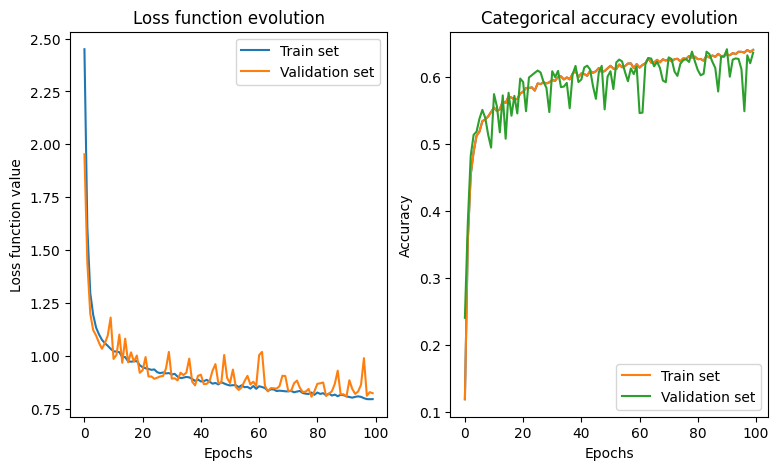

In [8]:
model3.plot_training_evolution()

In [9]:
# Save the pretrained model
model3.save_model(dir='../../../output/CNN_models/', name='LeNet_small')

/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Original LeNet-5

In [10]:
architecture = tf.keras.Sequential([
    layers.Conv2D(6,(5,5), activation = 'tanh', input_shape = (32,32,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(16,(5,5), activation = 'tanh'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(120,(5,5), activation = 'tanh'),

    layers.Flatten(),
    layers.Dense(84, activation='tanh'),
    layers.Dense(13, activation = 'softmax')
])
architecture.summary()

model4 = CNN_model(train_dataset, test_dataset, architecture)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten_1 (Flatten)         (None, 120)              

In [11]:
model4.train_model(training_epochs= 100, learning_rate= 0.001, patience_epochs= 50)
# model4.predict_val()

Training completed. Number of epochs: 100 , Final training loss: 0.7374587059020996 , Final validation loss: 0.8598069548606873
Final accuracy: 0.6606875061988831 Final validation accuracy: 0.6102499961853027


In [12]:
model4.predict_test()

625/625 [==============================] - 1s 1ms/step
Prediction results for the test set
Average F1 score: 0.5770759292314014

Confusion matrix:
tf.Tensor(
[[1272  113   57   26    3    0    0    0    0    0    0    0    0]
 [1128  254  115   43    1    1    0    0    0    1    0    0    0]
 [ 112  109  754  438   50    6    3    0    0    0    0    0    0]
 [  49   21  436  873  194   16   12    2    0    0    0    0    0]
 [  15    2   38  492  744  124   35    4    2    0    0    0    0]
 [   3    0    2   58  365  756  343   34   12    3    0    0    0]
 [   1    0    0   15   54  371  896  165   21   10    2    0    0]
 [   0    0    0    4    4   35  402  812  186   86   13    0    0]
 [   0    0    0    3    2   20  198  815  331  209   15    0    0]
 [   0    0    0    0    0    3   58  387  343  683   57    3    0]
 [   0    0    0    0    0    0    7    2    7  108 1425   58    0]
 [   0    0    0    0    0    0    0    0    0    1   70 1453   12]
 [   0    0    0    0    0

Training loss: 0.7374587059020996 , Validation loss: 0.8598069548606873
Training accuracy: 0.6606875061988831 , Validation accuracy: 0.6102499961853027


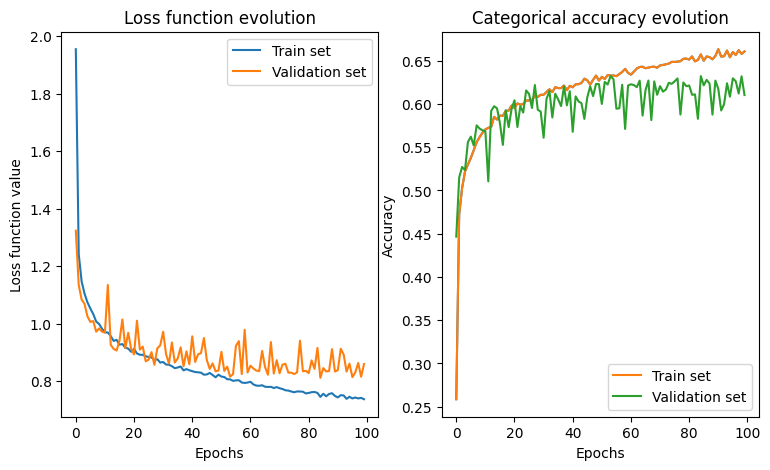

In [13]:
model4.plot_training_evolution()

In [14]:
# Save the pretrained model
model4.save_model(dir='../../../output/CNN_models/', name='LeNet_5')

/Users/ec270266/anaconda3/envs/wavediff/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plotting

625/625 [==============================] - 1s 1ms/step


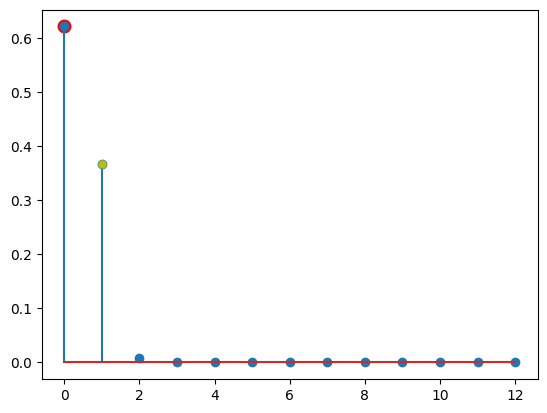

In [15]:
out = model4.model.predict(model4.x_test)
idx = 0
plt.stem(out[idx])
if np.argmax(out[idx]) == model4.y_test[idx]:
    o_color = 'green'
else:
    o_color = 'red'
plt.scatter(np.argmax(out[idx]), out[idx][np.argmax(out[idx])], color=o_color, marker='o', linewidths=4)
plt.scatter(model4.y_test[idx], out[idx][model4.y_test[idx]], color='y',linewidths=0.1, zorder=2)
plt.show()

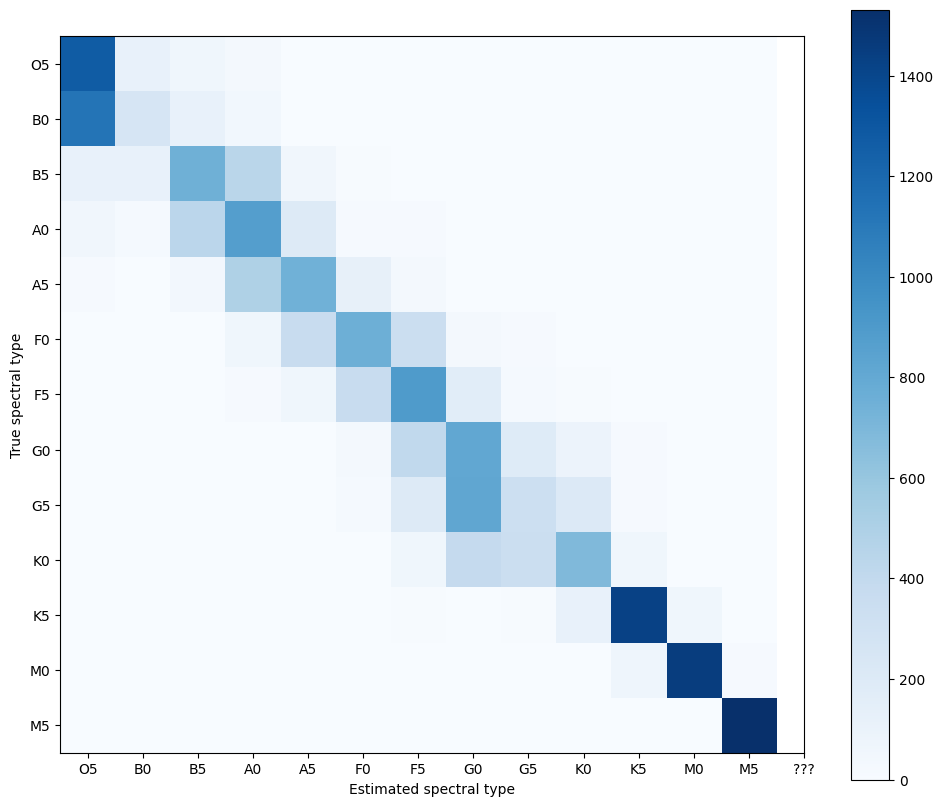

In [16]:
# Plot the confusion matrix

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

confusion_matrix = tf.math.confusion_matrix(model4.y_test, np.argmax(out, axis=1))
plt.figure(figsize= (12,10))
heatmap = plt.imshow(confusion_matrix[:13,:], cmap='Blues')
plt.xticks(np.arange(14), star_class_labels + ['???'])
plt.yticks(np.arange(13), star_class_labels)
plt.colorbar(heatmap)
plt.xlabel("Estimated spectral type")
plt.ylabel("True spectral type")
plt.show()